# Set 2

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import njit, prange


## 2.1 Diffusion Limited Aggregation (**DLA**)

The diffusion-limited aggregation (**DLA**) is a growth model based on diffusing particles.  The growth is started with a single seed (just a small square object in a single lattice point, at the bottom of the computational domain).  As described in detail in the lecture notes, **DLA** can be modeled by solving the time-independent diffusion equation (i.e. the Laplace equation), locating growth candidates around the cluster, and assigning a growth probability \( $p_g$ \) for each growth candidate, as a function of the concentration of diffusing nutrients at that growth location.  Next, a single growth candidate is added to the cluster with probability \( $p_g$ \).  After this growth step, the diffusion equation is again solved, and the process is iterated for a large number of growth steps.  You currently have almost all the tools available for a simulation of the **DLA** growth model.  Let us take a closer look at the growth model itself, allowing you to insert this into your programs.  A growth candidate is basically a lattice site that is not part of the object, but whose north, east, south, or west neighbor is part of the object. the object.


The probability for growth at each of the growth candidates is calculated by

$$
p_g(i,j) = \frac{c_{i,j}^\eta}{\sum_{\mathrm{growth\ candidates}} c_{i,j}^\eta}
$$

The parameter $\eta$ determines the shape of the object. For $\eta$ = 1 we get the normal DLA cluster. For $\eta$ < 1 the object becomes more compact (with $\eta$ = 0 resulting in the Eden cluster), and for $\eta$ > 1 the cluster becomes more open (and finally resembles say a lightning flash).

Modelling the growth is now a simple procedure.  A set is created of all growth candidates with their associated weights, and a single candidate is chosen. Hint: use `numpy.choice` with the $p$ parameter for this.

---

### **A**. (4 points)
Implement the growth model, paying special attention to the calculation of the growth probabilities. Run a number of growth simulations. Try to do this for a domain of size 100 × 100 and investigate the influence of the $\eta$ parameter. Can you still optimise by setting your $\omega$ parameter in the SOR iteration to a specific value?

Hint: the SOR iteration is run over and over again on a slowly growing object. As
the growth step is constructed in such a way that on average only one lattice site
is grown to the object, the concentration fields will hardly change. Therefore, it is
advantageous to start a new SOR iteration with the solution of the previous growth
step. Also, you can start the simulation with the analytical result for the empty
system, the linear concentration gradient of this equation

$$
\lim\limits_{t \to \infty} c(y,t) = y.
$$


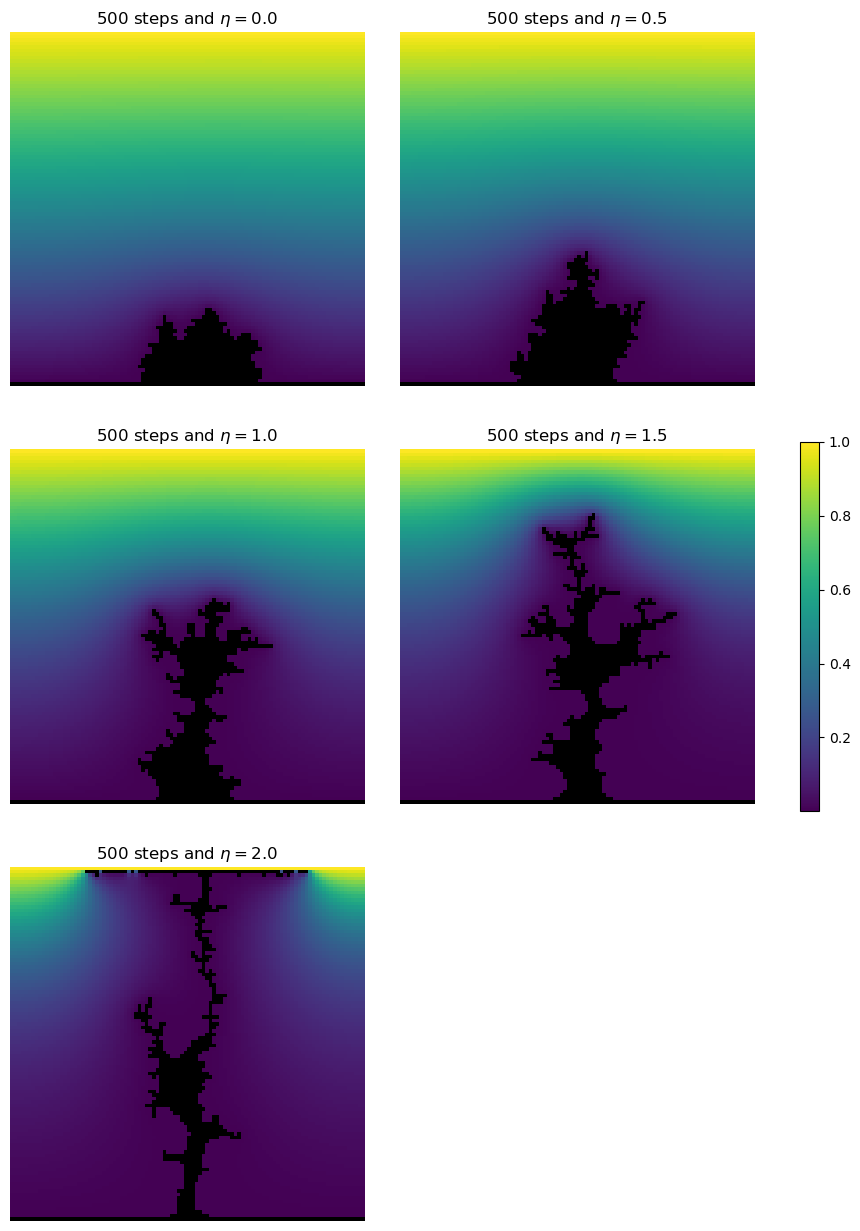

In [148]:
# Initialize the concentration field and DLA seed at the bottom center
def initialize_domain(N: int) -> tuple:
    c = np.zeros((N, N))
    c[:, -1] = 1  # Right boundary condition (ensuring diffusion)
    objects = np.zeros_like(c, dtype=bool)
    objects[N//2, 1] = True  # Seed at the bottom center
    return c, objects

# Solve the Laplace equation using the Successive Over-Relaxation (SOR) method
@njit
def SOR(c: np.ndarray, objects: np.ndarray, omega: float, tolerance: float, max_iter: int) -> int:
    N = c.shape[0]
    for iter in range(max_iter):
        # Boundary conditions
        # Corrected SOR boundary conditions
        c[:, -1] = 1.  # Right boundary = 1
        c[:, 0] = 0.   # Left boundary = 0
        c[0, :] = c[1, :]  # Top boundary = second row
        c[-1, :] = c[-2, :]  # Bottom boundary = second last row
        
        delta = 0.
        for i in range(1, N-1):
            for j in range(1, N-1):
                if objects[i, j]:
                    continue
                old_c = c[i, j]
                # Over-relaxation update
                c[i, j] = max(omega * 0.25 * (c[i-1, j] + c[i+1, j] + c[i, j-1] + c[i, j+1]) + (1 - omega) * c[i, j], 0)
                delta = max(delta, abs(c[i, j] - old_c))

        if delta <= tolerance:
            break
    return iter  # Return the number of iterations

def choose_site(c: np.ndarray, objects: np.ndarray, eta: float) -> tuple:
    # Identify potential growth sites by checking neighboring occupied sites
    left = np.roll(objects, -1, axis=0)
    left[-1, :] = False  # Prevent wrapping around bottom boundary
    right = np.roll(objects, 1, axis=0)
    right[0, :] = False  # Prevent wrapping around top boundary
    up = np.roll(objects, 1, axis=1)
    up[:, 0] = False  # Prevent wrapping around left boundary
    down = np.roll(objects, -1, axis=1)
    down[:, -1] = False  # Prevent wrapping around right boundary

    temp = np.logical_or(left, right)
    temp = np.logical_or(temp, up)
    temp = np.logical_or(temp, down)
    growth_candidates = np.logical_and(temp, ~objects)  # Sites adjacent to existing objects

    # Get all potential growth sites
    row, col = np.where(growth_candidates)

    # Ensure numerical stability by preventing division by zero
    c_values = c[row, col]
    c_values[c_values <= 1e-6] = 1e-6  # Replace extremely small values with a minimum threshold

    sum_c = np.sum(c_values**eta)
    if sum_c == 0 or np.isnan(sum_c):
        return None, None  # No valid growth probabilities

    # Compute probability of selecting each site
    pg = c_values**eta / sum_c  

    # Choose a growth site based on the computed probability
    growth_site_idx = np.random.choice(len(row), size=1, p=pg)

    return row[growth_site_idx][0], col[growth_site_idx][0]

# Simulates the DLA growth process
def DLA_growth(c: np.ndarray, objects: np.ndarray, eta: float, DLA_iter: int, 
               omega: float=1.7, tolerance: float=1e-4, max_iter: int=10000) -> list:
    iters = []
    for i in range(DLA_iter):
        sor_iter = SOR(c, objects, omega, tolerance, max_iter)
        iters.append(sor_iter)

        if sor_iter == max_iter:
            print(f'Warning: SOR did not converge in {max_iter} iterations')

        x, y = choose_site(c, objects, eta)
        if x is None:
            break  # No more valid growth sites

        objects[x, y] = True
        c[x, y] = 0.

    return iters

def plot_all_objects(N: int, eta_values: list, DLA_iter: int, omega: float=1.7):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    axes = axes.flatten()
    
    for i, eta in enumerate(eta_values):
        c, objects = initialize_domain(N)
        DLA_growth(c, objects, eta, DLA_iter, omega)
        
        cmap = plt.cm.viridis
        cmap.set_under('black')
        
        img = axes[i].imshow(c.T, origin='lower', cmap=cmap, vmin=1e-4)
        axes[i].set_title(fr'500 steps and $\eta = {eta}$')
        axes[i].axis('off')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.subplots_adjust(hspace=0.05, wspace=0.1)
    fig.colorbar(img, ax=axes, location="right", shrink=0.3)
    plt.savefig('A_eta.png', dpi=300, bbox_inches='tight')
    plt.show()

# Execution
if __name__ == "__main__":
    N = 100
    DLA_iter = 500
    eta_values = [0.0, 0.5, 1.0, 1.5, 2.0]
    plot_all_objects(N, eta_values, DLA_iter)



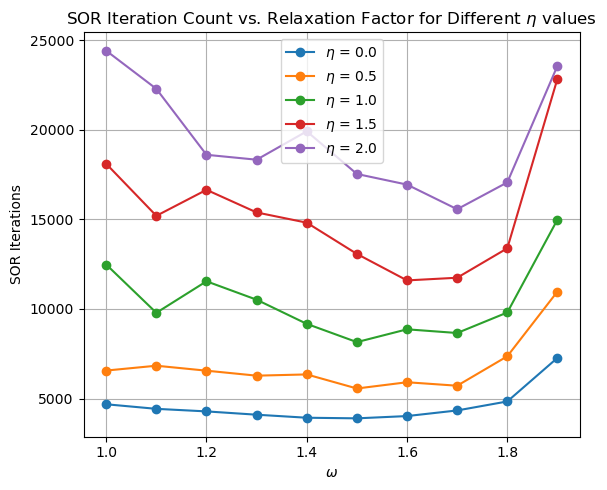

Optimal ω for η = 0.0: 1.5000000000000004
Optimal ω for η = 0.5: 1.5000000000000004
Optimal ω for η = 1.0: 1.5000000000000004
Optimal ω for η = 1.5: 1.6000000000000005
Optimal ω for η = 2.0: 1.7000000000000006


In [5]:
# Define a more refined range of omega values
omega_values = np.arange(1.0, 1.95, 0.1)  # ω from 1.0 to 2.0 with step 0.1
eta_values = [0.0, 0.5, 1.0, 1.5, 2.0]  # Different η values
iterations_dict = {eta: [] for eta in eta_values}
optimal_omega_dict = {}

# Run SOR with different ω and η values
for eta in eta_values:
    min_iterations = float("inf")
    best_omega = None
    for omega in omega_values:
        c, objects = initialize_domain(N)
        iterations = DLA_growth(c, objects, eta, DLA_iter, omega)
        # Compute total iterations instead of average
        total_iterations = sum(iterations)
        iterations_dict[eta].append(total_iterations)
        
        if total_iterations < min_iterations:
            min_iterations = total_iterations
            best_omega = omega
    
    optimal_omega_dict[eta] = best_omega

# Store results for different η values
plt.figure(figsize=(6, 5))
for eta in eta_values:
    plt.plot(omega_values, iterations_dict[eta], marker='o', linestyle='-', label=f"$\\eta$ = {eta}")

plt.xlabel(r'$\omega$')
plt.ylabel('SOR Iterations')
plt.title(r'SOR Iteration Count vs. Relaxation Factor for Different $\eta$ values')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("A_omega.png", dpi=300, bbox_inches="tight")

plt.show()

# Print optimal omega for each eta
for eta, best_omega in optimal_omega_dict.items():
    print(f"Optimal ω for η = {eta}: {best_omega}")


### **Optional**: (1 point) 
Think of a way to reduce the time required to solve the diffusion equation. Compare your results for the 100 × 100 grid in question A and try larger grid sizes. Some suggestions: parallelize one of the iteration schemes in the previous exercise set, and possibly use a GPU to do the calculations.

## **Be careful when run this cell, once you run it, the parallelization will lead MUCH MUCH slower execution to other cells!!! Use 'restart kernel' to avoid this issue.**

In [28]:
# Define the optimized parallel SOR method
@njit(parallel=True)
def SOR_parallel(c: np.ndarray, objects: np.ndarray, omega: float, tolerance: float, max_iter: int) -> int:
    N = c.shape[0]
    for iter in range(max_iter):
        # Boundary conditions
        c[:, -1] = 1.  # Right boundary = 1
        c[:, 0] = 0.   # Left boundary = 0
        c[0, :] = c[1, :]  # Top boundary = second row
        c[-1, :] = c[-2, :]  # Bottom boundary = second-to-last row

        delta = 0.
        for i in prange(1, N-1):  # Parallel loop
            for j in range(1, N-1):
                if objects[i, j]:
                    continue
                old_c = c[i, j]
                c[i, j] = max(omega * 0.25 * (c[i-1, j] + c[i+1, j] + c[i, j-1] + c[i, j+1]) + (1 - omega) * c[i, j], 0)
                delta = max(delta, abs(c[i, j] - old_c))

        if delta <= tolerance:
            break
    return iter

# Compare execution time for sequential vs parallel SOR
N_values = [100, 500, 1000]  # Run for different grid sizes
omega = 1.7  # Relaxation factor
tolerance = 1e-4
max_iter = 10000

# Store results
results = {}
for N in N_values:
    # Initialize the grid
    c_seq, objects_seq = np.zeros((N, N)), np.zeros((N, N), dtype=bool)
    c_par, objects_par = np.copy(c_seq), np.copy(objects_seq)

    # Measure time for original sequential SOR
    start_time = time.time()
    SOR(c_seq, objects_seq, omega, tolerance, max_iter)
    sequential_time = time.time() - start_time

    # Measure time for parallel SOR
    start_time = time.time()
    SOR_parallel(c_par, objects_par, omega, tolerance, max_iter)
    parallel_time = time.time() - start_time

    results[N] = (sequential_time, parallel_time)

    # Print the time comparison for different grid size N
    print(f"N = {N}")
    print(f"Sequential SOR Time: {sequential_time:.4f} seconds")
    print(f"Parallel SOR Time: {parallel_time:.4f} seconds")
    print(f"Speedup Factor: {sequential_time / parallel_time:.2f}x\n")


N = 100
Sequential SOR Time: 0.0848 seconds
Parallel SOR Time: 0.5015 seconds
Speedup Factor: 0.17x

N = 500
Sequential SOR Time: 4.3717 seconds
Parallel SOR Time: 0.9231 seconds
Speedup Factor: 4.74x

N = 1000
Sequential SOR Time: 17.8441 seconds
Parallel SOR Time: 3.1898 seconds
Speedup Factor: 5.59x



---

## 2.2 Monte Carlo simulation of DLA

DLA can also be simulated by releasing random walkers on a grid, and letting them
walk until they hit the cluster. When they hit, the walkers are stopped and become
part of the cluster.
One random walker at a time is released in the system. It moves in steps, which
are randomly chosen to be one lattice point up, down, left, or right. If the walker
reaches a cell neighboring the cluster, the walker is stopped there, so that the cell
with the walker becomes part of the cluster.
To simulate with the same boundary conditions as above, start the walkers on a
randomly chosen point on the top boundary. If a walker walks out of the system
on the top or bottom boundary it is removed and a new one created instead. If it
walks across the left or right boundary, it should enter the system from the other
side, as periodic boundary conditions were assumed in the horizontal direction.

### **B**. (2 points) 
Implement the Monte Carlo version of DLA. Compare the resulting 
cluster to those obtained with the diffusion equation.

### **C**. (1 point)
In this model, the $\eta$ parameter is no longer easily variable; it is fixed to 1.  However, another parameter can be introduced, namely a sticking probability $p_s$.  The sticking rule can then be stated in the following way:  if the walker enters a cell that is a neighbor of the cluster, it stops there with probability $p_s$.  If it does not stick, the walk continues as normal.  The walker is, however, not allowed to move into a site belonging to the cluster.  Run the simulation for different values of $p_s$, and plot the results.  How does the cluster shape depend on $p_s$ ?

---

## 2.3 The Gray-Scott model - A reaction-diffusion system

The Gray-Scott model (J. E. Pearson, *Science*, Vol 261, 5118, 189-192 (1993))  
describes a system of chemical reactions, involving the two chemicals $U$ and $V$.  
Both chemicals diffuse in the system and also react with each other.  The reaction rate at any point in space is determined by the *local* concentrations of $U$ and $V$.  
The reactions are:

$$
U + 2V \rightarrow 3V \tag{15}
$$

$$
V \rightarrow P \tag{16}
$$

$U$ is continuously fed into the system. It then reacts with $V$ to produce more $V$.  $V$ spontaneously decays into $P$, a reaction product that does not interact with $U$ and $V$.  The first reaction is said to be autocatalytic since the reaction product $V$ enhances the production of itself.

If we let $u$ and $v$ denote the concentrations of $U$ and $V$,  
the following equations can be formulated:

$$
\frac{\partial u}{\partial t} = D_u \nabla^2 u - uv^2 + f(1 - u), \tag{17}
$$

$$
\frac{\partial v}{\partial t} = D_v \nabla^2 v + uv^2 - (f + k)v. \tag{18}
$$

Here, $f$ controls the rate at which $U$ is supplied,  
and $f + k$ controls the rate at which $V$ decays.  For different values of $f$ and $k$, a large variety of behaviors can be observed.  Some result in stable patterns, while others remain time-dependent.

### **D**. (3 points)  
Implement the Gray-Scott model in two dimensions.  Explain the discretization and how the equations and boundary conditions are implemented in the program (you may choose which boundary conditions to use).  Plot the resulting concentrations of $U$ and/or $V$ for several choices of the parameters. The time-dependent diffusion program from Set 1 can be used as a base.  In this case, there are two variables to keep track of.  For parameters, start with $delta t = 1 $, $delta x = 1$,  $D_u = 0.16 $, $D_v = 0.08$, $f = 0.035$, $k = 0.060$.  For the initial conditions, you can take $u = 0.5$ everywhere in the system,  and $v = 0.25$ in a small square in the center of the system, and 0 outside.  Try adding a small amount of noise too.